In [1]:
import fcl as fcl
import numpy as np
import networkx as nx
import random
import matplotlib.pyplot as plt
import math

In [2]:
# Boxes with given side lengths
geom1 = fcl.Box(1.0, 1.0, 1.0) 
tf1 = fcl.Transform(np.array([2.0, 2.0, 0.5]))
obj1 = fcl.CollisionObject(geom1, tf1)

geom2 = fcl.Box(1.0, 1.0, 1.0)
tf2 = fcl.Transform(np.array([5.0, 3.0, 0.5]))
obj2 = fcl.CollisionObject(geom2, tf2)

geom3 = fcl.Box(1.0, 1.0, 1.0)
tf3 = fcl.Transform(np.array([0.5, 4.5, 0.5]))
obj3 = fcl.CollisionObject(geom3, tf3)

geom4 = fcl.Box(1.0, 1.0, 1.0)
tf4 = fcl.Transform(np.array([7.0, 3.0, 0.5]))
obj4 = fcl.CollisionObject(geom4, tf4)

geom5 = fcl.Box(1.0, 1.0, 1.0)
tf5 = fcl.Transform(np.array([4.0, 6.0, 0.5]))
obj5 = fcl.CollisionObject(geom5, tf5)


# Cylinder with given radius and height along z-axis
geom6 = fcl.Cylinder(0.5, 1.0)
tf6 = fcl.Transform(np.array([6.0, 0.5, 0.5]))
obj6 = fcl.CollisionObject(geom6, tf6)

geom7 = fcl.Cylinder(0.5, 1.0)
tf7 = fcl.Transform(np.array([3.0, 5.0, 0.5]))
obj7 = fcl.CollisionObject(geom7, tf7)

# Fetch will be model as a Cylinder when the arm is folded in. We will over dimension the 
# cylinder with a radius of 0.4 m
geom_robot = fcl.Cylinder(0.4, 1.5)
tf_robot = fcl.Transform(np.array([0.0, 0.0, 0.75]))
obj_robot = fcl.CollisionObject(geom_robot, tf_robot)

In [3]:
geoms = [geom1, geom2, geom3, geom4, geom5, geom6, geom7, geom_robot]
objs = [obj1, obj2, obj3, obj4, obj5, obj6, obj7, obj_robot]
names = ['obj1', 'obj2', 'obj3', 'obj4', 'obj5', 'obj6', 'obj7', 'obj_robot']

# Create map from geometry IDs to objects
geom_id_to_obj = { id(geom) : obj for geom, obj in zip(geoms, objs) }

# Create map from geometry IDs to string names
geom_id_to_name = { id(geom) : name for geom, name in zip(geoms, names) }

# Create manager
manager = fcl.DynamicAABBTreeCollisionManager()
manager.registerObjects(objs)
manager.setup()


In [4]:
# We define the world limits
world_x_lim = [-0.5, 8.5]
world_y_lim = [-0.5, 8.5]
max_dist = 10

G = nx.Graph()

n_count = 0
G.add_node(n_count)
G.nodes[n_count]['pos'] = (0, 0)

goal = (8, 8)
min_goal = 0.3

step_size = 1

In [5]:
def generate_random_node():
    x = random.uniform(world_x_lim[0], world_x_lim[1])
    y = random.uniform(world_y_lim[0], world_y_lim[1])
    return (x, y)

In [6]:
def nearest_neighbor(node):
    dist = np.zeros(len(G.nodes()))
    for i in range(len(G.nodes())):
        dist[i] = math.dist(node, G.nodes[i]['pos'])

    min_dist = np.min(dist) 
    nearest_neighbor_node = np.argmin(dist)
    nearest_neighbor_coords = G.nodes[nearest_neighbor_node]['pos']
    return (nearest_neighbor_node, nearest_neighbor_coords)

In [8]:
def collision_free(point):
    
    collision = False
    
    # We create a cylinder object for the robot and place it on the new position.
    # Then we clear the manager, load all the objects again
    tf_robot = fcl.Transform(np.array([point[0], point[1], 0.75]))
    obj_robot = fcl.CollisionObject(geom_robot, tf_robot)
    manager.clear()
    manager.registerObjects([obj1, obj2, obj3, obj4, obj5, obj6, obj7, obj_robot])

    
    # We create a collision request structure and run the collision request
    crequest = fcl.CollisionRequest(num_max_contacts=100, enable_contact=True)
    cdata = fcl.CollisionData(crequest, fcl.CollisionResult())
    manager.collide(cdata, fcl.defaultCollisionCallback)

    # Extract collision data from contacts and use that to infer set of
    # objects that are in collision
    objs_in_collision = set()

    # We check for all object in collision and add the to a list
    for contact in cdata.result.contacts:
      # Extract collision geometries that are in contact
      coll_geom_0 = contact.o1
      coll_geom_1 = contact.o2

      # Get their names
      coll_names = [geom_id_to_name[id(coll_geom_0)], geom_id_to_name[id(coll_geom_1)]]
      coll_names = tuple(sorted(coll_names))
      objs_in_collision.add(coll_names)
      collision = True

    # This is the list of all objects in collision
    #for coll_pair in objs_in_collision:
      #print('Object {} in collision with object {}!'.format(coll_pair[0], coll_pair[1]))
    
    if len(objs_in_collision) == 0:
        return True
    return False
    

In [10]:
def new_state(p1, p2):
    dist = math.dist(p1, p2)
    if dist < step_size:
        return p2
    else:
        x = p1[0] + step_size * (p2[0] - p1[0]) / dist
        y = p1[1] + step_size * (p2[1] - p1[1]) / dist
        return (x, y)

In [11]:
def plan():
    max_iter = 1000
    n_count = 1
    while True:
        rand_node = generate_random_node()
        nearest_node, nearest_node_coords = nearest_neighbor(rand_node)
        new_node = new_state(nearest_node_coords, rand_node)
        if collision_free(new_node):
            G.add_node(n_count)
            G.nodes[n_count]['pos'] = new_node
            G.add_edge(nearest_node, n_count)
            n_count += 1
            if math.dist(new_node, goal) <= step_size:
                G.add_node(n_count)
                G.nodes[n_count]['pos'] = (goal[0], goal[1])
                G.add_edge(n_count-1, n_count)
                return nx.shortest_path(G, 0, n_count)

    #If no path found
    return None

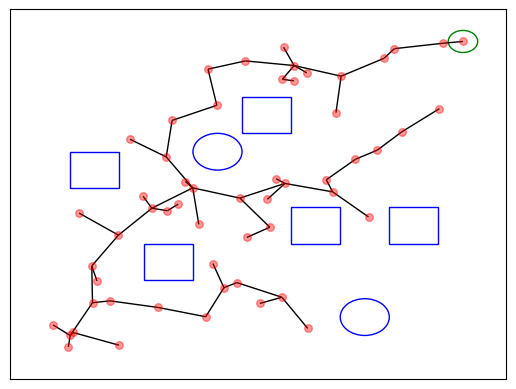

Shortest Path
n_count: 56
nodes: [0, 1, 2, 4, 5, 7, 11, 12, 14, 17, 23, 24, 25, 33, 53, 54, 55]


In [12]:
plt.axes()
square1 = plt.Rectangle((1.5,1.5),1,1, fill=False, edgecolor='blue')
square2 = plt.Rectangle((4.5,2.5),1,1, fill=False, edgecolor='blue')
square3 = plt.Rectangle((0,4),1,1, fill=False, edgecolor='blue')
square4 = plt.Rectangle((6.5,2.5),1,1, fill=False, edgecolor='blue')
square5 = plt.Rectangle((3.5,5.5),1,1, fill=False, edgecolor='blue')
circ1 = plt.Circle((6,0.5), radius=0.5, fill=False, edgecolor='blue')
circ2 = plt.Circle((3,5), radius=0.5, fill=False, edgecolor='blue')
circ_goal = plt.Circle(goal, radius=min_goal, fill=False, edgecolor='green')
plt.gca().add_patch(square1)
plt.gca().add_patch(square2)
plt.gca().add_patch(square3)
plt.gca().add_patch(square4)
plt.gca().add_patch(square5)
plt.gca().add_patch(circ1)
plt.gca().add_patch(circ2)
plt.gca().add_patch(circ_goal)

p = plan()

n_count = len(G.nodes())

nodes = []
for i in range(n_count):
    nodes.append(list(G.nodes[i]['pos']))
    
nx.draw_networkx_nodes(G, nodes, node_size = 30, node_color='r', alpha=0.4)
nx.draw_networkx_edges(G,nodes)

plt.show()

print('Shortest Path')
print('n_count: {}'.format(n_count))
print('nodes: {}'.format(p))